# Data Science Case Study: Revenue Forecasting & Customer Segmentation
 
## Introduction
A global direct selling company with a diverse customer base and a strong focus on data-driven business growth. In this case study, I take on the role of a data scientist tasked with providing actionable insights to support the company's strategic decisions.

**Business Challenge:**
- Forecast future revenue for each customer and region to support sales planning and resource allocation.
- Segment customers based on business behaviors and growth to enable targeted marketing and retention strategies.
- Evaluate the impact of a price increase on buyer behavior, providing evidence-based recommendations for pricing strategy.

**My Approach:**
Combining rigorous data validation, advanced modeling, and clear communication to deliver insights that drive business value. This notebook demonstrates my end-to-end workflow, from data exploration to actionable recommendations, with a focus on transparency and impact.

---

## Analytical Approach & Notebook Structure
This notebook is organized to reflect a real-world data science workflow, emphasizing both technical rigor and business impact:
- **Data Understanding & Validation:** Ensuring data quality and relevance before modeling.
- **Revenue Forecasting:** Applying and comparing time series and machine learning models to predict future revenue at the customer and region level.
- **Customer Segmentation:** Using clustering techniques to identify distinct customer groups and track their migration over time.
- **Business Insights & Recommendations:** Translating analytical findings into actionable strategies for the company.

Each section begins with a brief explanation of the methodology and ends with key findings and their business implications.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Revenue Forecasting

## Why Revenue Forecasting Matters for the Company
Accurate revenue forecasting empowers the company to:
- Optimize inventory and supply chain planning
- Set realistic sales targets and incentives
- Identify high-potential customers and regions for growth
 
**Modeling Philosophy:**
I use both individual and global models to balance interpretability and predictive power. All models are validated for robustness, and results are communicated with business stakeholders in mind.

## Load Data
* Columns: Geography, Customer ID, Region Code, Year Revenue
* Rows: 109 customers × 8 years (2017–2024) = 872 rows
* Structure: Each customer has 8 consecutive yearly revenue entries.
* Note: Geography is always “North America”, so it can be excluded from modeling.

In [2]:
# Load the forecasting dataset
forecast_df = pd.read_csv('Forecasting.csv', dtype={'Geography': str, 'Customer ID': int, 'Region Code': str})

# Make sure each customer’s entries are sorted by year
forecast_df = forecast_df.sort_values(['Customer ID', 'Year'], ascending=[True, True]) 
forecast_df['Customer ID'] = forecast_df['Customer ID'].astype('str')

# Quick preview
forecast_df.head(16)

,Geography,Customer ID,Region Code,Year,Revenue
0,NORTH AMERICA,560,MPMO,2017,1620818.85
1,NORTH AMERICA,560,MPMO,2018,1606752.30
2,NORTH AMERICA,560,MPMO,2019,1501943.36
3,NORTH AMERICA,560,MPMO,2020,1588021.78
4,NORTH AMERICA,560,MPMO,2021,1616313.56
5,NORTH AMERICA,560,MPMO,2022,1466484.42
6,NORTH AMERICA,560,MPMO,2023,1251107.33
7,NORTH AMERICA,560,MPMO,2024,735804.15
8,NORTH AMERICA,585,2N1,2017,821884.72
9,NORTH AMERICA,585,2N1,2018,779454.92


## Data sanity check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Geography    872 non-null    object 
 1   Customer ID  872 non-null    object 
 2   Region Code  872 non-null    object 
 3   Year         872 non-null    int64  
 4   Revenue      872 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 34.2+ KB
Missing values in each column:
 Geography      0
Customer ID    0
Region Code    0
Year           0
Revenue        0
dtype: int64
Unique values in Geography: 1
Unique values in Customer ID: 109
Unique values in Region Code: 20
Unique values in Year: 8
Min and Max values of Year: 2017 2024
Number of duplicate rows: 0
Duplicate Customer-Year entries: 0
Count (Year Continuity per Customer)
 Year
True    109
Name: count, dtype: int64
count
8    109
Name: count, dtype: int64
Data types of each column:
 Geography       object
Customer ID  

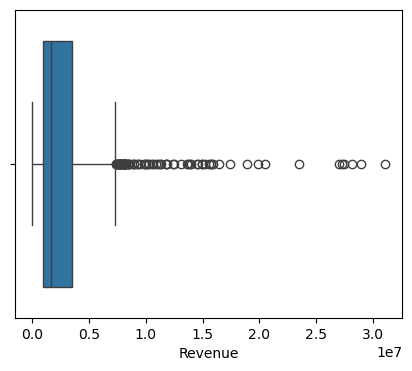

In [3]:
# Check information about the dataset
forecast_df.info()

# Check for missing values
print("Missing values in each column:\n", forecast_df.isnull().sum())

# Check for unique values in categorical columns
print("Unique values in Geography:", forecast_df['Geography'].nunique())
print("Unique values in Customer ID:", forecast_df['Customer ID'].nunique())
print("Unique values in Region Code:", forecast_df['Region Code'].nunique())
print("Unique values in Year:", forecast_df['Year'].nunique())

print("Min and Max values of Year:", forecast_df['Year'].min(), forecast_df['Year'].max())  # Should be 2017–2024

# Check for duplicates
print("Number of duplicate rows:", forecast_df.duplicated().sum())
print("Duplicate Customer-Year entries:", forecast_df.duplicated(subset=['Customer ID', 'Year']).sum())

# Check for Year Continuity per Customer
print("Count (Year Continuity per Customer)\n", 
   (forecast_df.sort_values(['Customer ID', 'Year'])
   .groupby('Customer ID')['Year']
   .apply(lambda x: x.is_monotonic_increasing and x.nunique() == 8)
   .value_counts())
)

# Check Number of Data Points per Customer
customer_counts = forecast_df['Customer ID'].value_counts()
print(customer_counts.value_counts())  # Should mostly be {8: N}

# Check for Negative or Zero Revenue
forecast_df[forecast_df['Revenue'] <= 0]

# Check the data types
print("Data types of each column:\n", forecast_df.dtypes)

#  Outlier Detection
plt.figure(figsize=(5, 4))
sns.boxplot(x=forecast_df['Revenue'])
plt.show()


## Exploratory Data Analysis

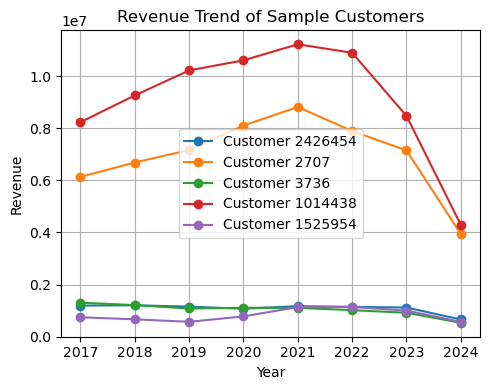

In [4]:
# Revenue trends of sample customers to get a sense of the data
sample_ids = forecast_df['Customer ID'].drop_duplicates().sample(5)

plt.figure(figsize=(5, 4))
for cid in sample_ids:
    customer_df = forecast_df[forecast_df['Customer ID'] == cid].sort_values('Year')
    plt.plot(customer_df['Year'], customer_df['Revenue'], marker='o', label=f'Customer {cid}')

plt.title('Revenue Trend of Sample Customers')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

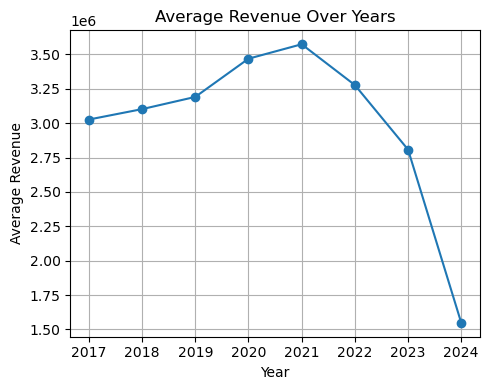

In [5]:
# Average Revenue Over Time
avg_revenue = forecast_df.groupby('Year')['Revenue'].mean()

plt.figure(figsize=(5, 4))
avg_revenue.plot(marker='o')
plt.title('Average Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

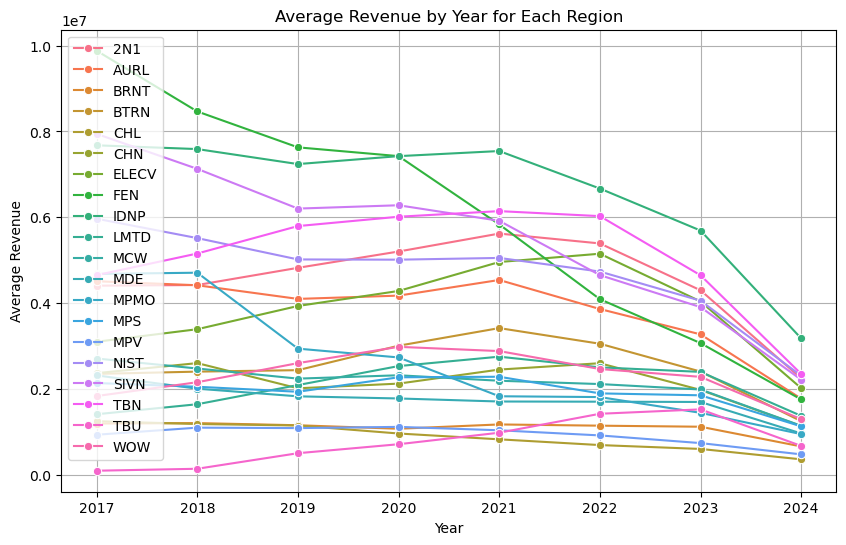

In [6]:
# Average Revenue Over Time by Region
avg_revenue_by_region = forecast_df.groupby(['Year', 'Region Code'])['Revenue'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_revenue_by_region, x='Year', y='Revenue', hue='Region Code', marker='o')
plt.title('Average Revenue by Year for Each Region')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

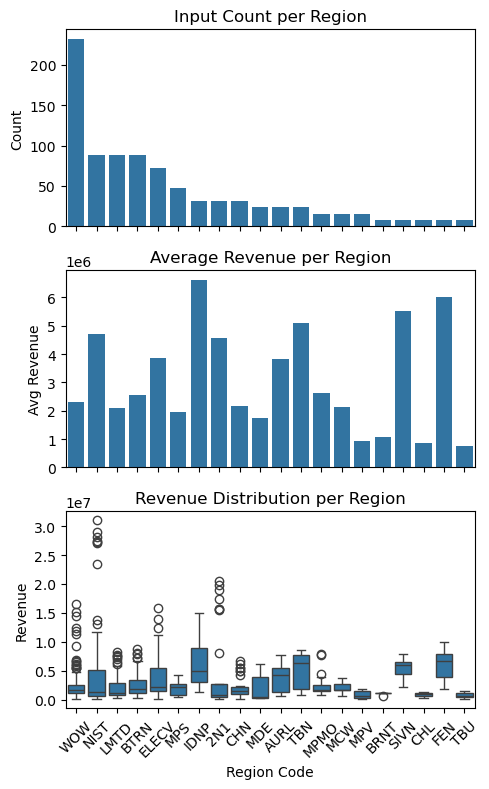

In [7]:
# More Plots Based on The Reginal Feature

fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)

# 1. Input Count per Region
sns.countplot(data=forecast_df, x='Region Code', ax=axes[0], order=forecast_df['Region Code'].value_counts().index)
axes[0].set_title('Input Count per Region')
axes[0].set_ylabel('Count')

# 2. Average Revenue per Region
region_avg = forecast_df.groupby('Region Code')['Revenue'].mean().reset_index()
sns.barplot(data=region_avg, x='Region Code', y='Revenue', ax=axes[1])
axes[1].set_title('Average Revenue per Region')
axes[1].set_ylabel('Avg Revenue')

# 3. Revenue Distribution per Region
sns.boxplot(data=forecast_df, x='Region Code', y='Revenue', ax=axes[2])
axes[2].set_title('Revenue Distribution per Region')
axes[2].set_ylabel('Revenue')
axes[2].set_xlabel('Region Code')

# Adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

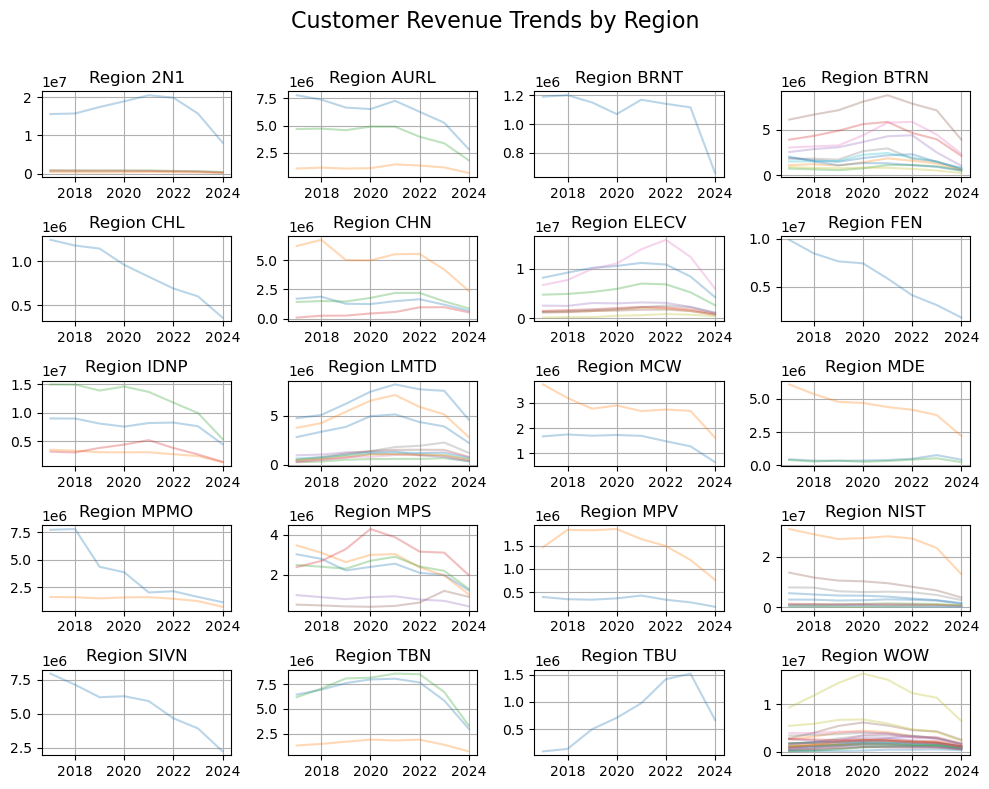

In [8]:
# Customer Revenue Trends by Region
regions = sorted(forecast_df['Region Code'].unique())
n_regions = len(regions)
ncols = 4
nrows = (n_regions + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 8), sharex=False, sharey=False)
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    subset = forecast_df[forecast_df['Region Code'] == region]
    for cid, group in subset.groupby('Customer ID'):
        ax.plot(group['Year'], group['Revenue'], alpha=0.3)
    ax.set_title(f'Region {region}')
    ax.grid(True)

fig.suptitle('Customer Revenue Trends by Region', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [9]:
# KMeans Clustering per Region (on 8-year revenue vectors)
# this could be used to identify similar customers within each region for training general prediction models 
# for the subset of customers
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

region_counts = forecast_df.groupby('Region Code')['Customer ID'].nunique()
valid_regions = region_counts[region_counts > 10].index.tolist() # Filter regions with more than 10 customers
filtered_df = forecast_df[forecast_df['Region Code'].isin(valid_regions)] # Select data only from these valid regions

pivot = filtered_df.pivot(index='Customer ID', columns='Year', values='Revenue').fillna(0) # reshapes the forecast_df DataFrame from long format to wide format

# Merge Region Code info
region_map = forecast_df[['Customer ID', 'Region Code']].drop_duplicates().set_index('Customer ID')
pivot['Region Code'] = region_map['Region Code']

# Cluster by region
for region in pivot['Region Code'].unique():
    region_data = pivot[pivot['Region Code'] == region].drop(columns='Region Code')
    scaler = StandardScaler()
    X = scaler.fit_transform(region_data)

    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X)

    print(f"\nRegion {region} Cluster Counts:")
    print(pd.Series(labels).value_counts())


Region NIST Cluster Counts:
0    8
2    2
1    1
Name: count, dtype: int64

Region WOW Cluster Counts:
0    20
2     8
1     1
Name: count, dtype: int64

Region LMTD Cluster Counts:
0    8
2    2
1    1
Name: count, dtype: int64

Region BTRN Cluster Counts:
1    7
0    3
2    1
Name: count, dtype: int64


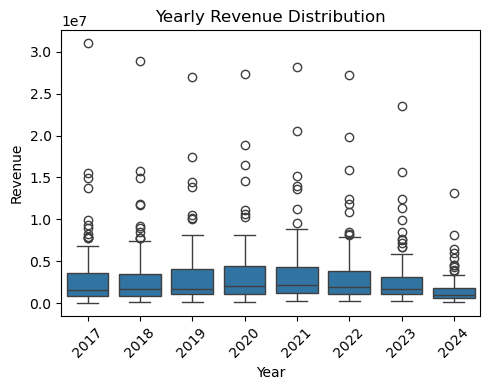

In [10]:
# Revenue Distribution by Year
plt.figure(figsize=(5, 4))
sns.boxplot(data=forecast_df, x='Year', y='Revenue')
plt.title('Yearly Revenue Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

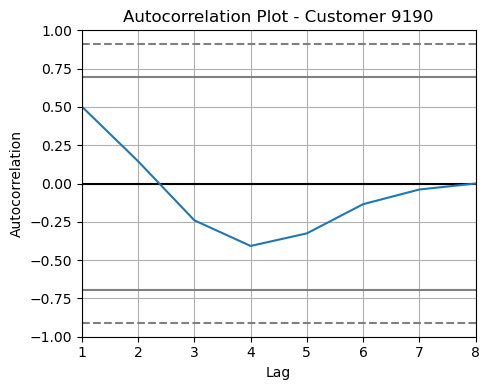

In [11]:
# Autocorrelation Plot for One Customer
example_id = forecast_df['Customer ID'].drop_duplicates().sample(1).iloc[0]
ts = forecast_df[forecast_df['Customer ID'] == example_id].sort_values('Year')['Revenue']

plt.figure(figsize=(5, 4))
autocorrelation_plot(ts)
plt.title(f'Autocorrelation Plot - Customer {example_id}')
plt.tight_layout()
plt.show()

### Key EDA Findings & Business Implications
- **Revenue patterns vary significantly by region and customer,** highlighting the need for tailored forecasting models.
- **Some customers show steady growth, while others are volatile or declining,** suggesting different engagement strategies.
- **No major data quality issues detected,** enabling reliable modeling.

*These insights inform the choice of modeling techniques and help the company prioritize high-growth segments for targeted actions.*

## Forecasting Revenue with Individual Models for Individual Customer

We use historical yearly revenue data from 2017 to 2024 for 109 customers. The goal is to forecast for 2025 and 2026. 

Because the number of data points per customer is limited, two simple models where chosen for forecasting without holdout data for testing:
1. Exponential smoothing
2. Polynominal regression

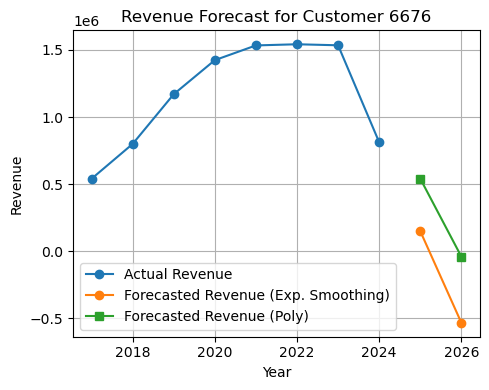

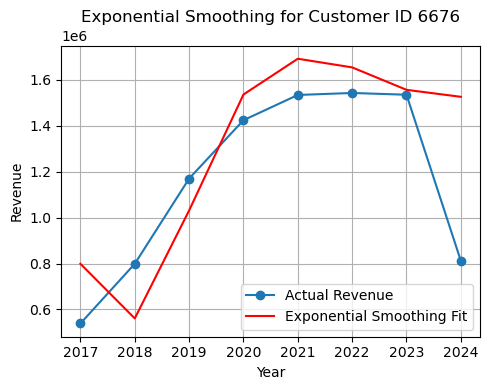

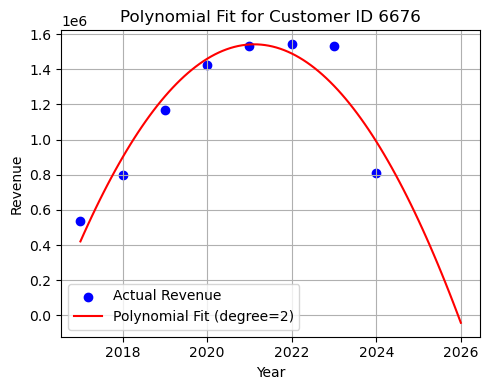

2025    540169.781525
2026    -41565.076843
dtype: float64

In [12]:
# Group data per customer
grouped = forecast_df.groupby('Customer ID')

# Apply exponential smoothing for one customer
def forecast_customer(group, forecast_num_of_years = 2, plot=False):
    """
    Forecast future revenue using exponential smoothing.

    Parameters:
        group (pd.DataFrame): Data for a single customer (must have 'Year' and 'Revenue')
        forecast_num_of_years (int): Years to forecast

    Returns:
        pd.Series: Forecasted revenue values indexed by forecast year
    """
    group = group.sort_values('Year')
    model = ExponentialSmoothing(group['Revenue'], trend='add', seasonal=None, initialization_method="estimated")
    fit = model.fit()
    forecast = fit.forecast(forecast_num_of_years)  # Forecast next 2 years

    if plot:
        plt.figure(figsize=(5, 4))
        plt.plot(group['Year'], group['Revenue'], marker='o', label='Actual Revenue')
        plt.plot(group['Year'], fit.fittedvalues, color='red', label='Exponential Smoothing Fit')
        plt.xlabel('Year')
        plt.ylabel('Revenue')
        plt.title(f'Exponential Smoothing for Customer ID {group["Customer ID"].iloc[0]}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return forecast

def forecast_customer_poly(group, degree=2, forecast_years=[2025, 2026], plot=False):
    """
    Forecast future revenue using polynomial regression.

    Parameters:
        group (pd.DataFrame): Data for a single customer (must have 'Year' and 'Revenue')
        degree (int): Degree of polynomial fit
        forecast_years (list): Years to forecast

    Returns:
        pd.Series: Forecasted revenue values indexed by forecast year
    """
    group = group.sort_values('Year')
    X = group['Year'].values.reshape(-1, 1)
    y = group['Revenue'].values

    # Transform input to polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Fit the model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Forecast
    X_forecast = np.array(forecast_years).reshape(-1, 1)
    X_forecast_poly = poly.transform(X_forecast)
    y_forecast = model.predict(X_forecast_poly)

    # For plotting
    if plot:
        # Generate smooth x values for the curve
        X_plot = np.linspace(2017, 2026, 100).reshape(-1, 1)
        X_plot_poly = poly.transform(X_plot)
        y_plot = model.predict(X_plot_poly)
        # Plot
        plt.figure(figsize=(5, 4))
        plt.scatter(X, y, color='blue', label='Actual Revenue')
        plt.plot(X_plot, y_plot, color='red', label=f'Polynomial Fit (degree={degree})')
        plt.xlabel('Year')
        plt.ylabel('Revenue')
        plt.title(f'Polynomial Fit for Customer ID {group["Customer ID"].iloc[0]}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return pd.Series(y_forecast, index=forecast_years)

# Example usage (replace with actual IDs from the dataset)
# Get a list of unique Customer IDs
unique_customers = forecast_df["Customer ID"].unique()
# Randomly select one Customer ID
random_customer_id = pd.Series(unique_customers).sample(1).iloc[0]
example = grouped.get_group(random_customer_id)

plt.figure(figsize=(5, 4))
plt.plot(example['Year'], example['Revenue'], marker='o', label='Actual Revenue')
plt.plot(example['Year'].iloc[-1] + np.arange(1, 3), forecast_customer(example), marker='o', label='Forecasted Revenue (Exp. Smoothing)')
plt.plot(example['Year'].iloc[-1] + np.arange(1, 3), forecast_customer_poly(example), marker='s', label='Forecasted Revenue (Poly)')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title(f'Revenue Forecast for Customer {random_customer_id}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the fit of the models
forecast_customer(example, plot=True)
forecast_customer_poly(example, plot=True)


## Train a Global Model for All Customers
RandomForest

In [13]:
# All necessary imports are now at the top of the notebook.
# The following code trains a global RandomForest model for all customers.

# Copy to avoid modifying original
df = forecast_df.copy()

# Encode categorical features
le = LabelEncoder()
df['Region_Code_Enc'] = le.fit_transform(df['Region Code'])
df['Customer_ID_Enc'] = le.fit_transform(df['Customer ID'])

# Features and target
features = ['Year', 'Region_Code_Enc', 'Customer_ID_Enc']
target = 'Revenue'

X_train = df[features]
y_train = df[target]

model = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=10)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

df['Predicted_Revenue'] = y_pred_train

###### Prepare future data for forecasting
future_years = [2025, 2026]
future_rows = []

# Get unique customers and region mappings
customers = df[['Customer ID', 'Customer_ID_Enc']].drop_duplicates()
regions = df[['Customer ID', 'Region Code', 'Region_Code_Enc']].drop_duplicates()

# Prepare future prediction rows
for year in future_years:
    for _, row in customers.iterrows():
        cid = row['Customer ID']
        cid_enc = row['Customer_ID_Enc']
        region_enc = regions[regions['Customer ID'] == cid]['Region_Code_Enc'].values[0]
        future_rows.append({'Year': year, 'Region_Code_Enc': region_enc, 'Customer_ID_Enc': cid_enc})

X_future = pd.DataFrame(future_rows)

# Predict
y_future = model.predict(X_future)

# Build forecast DataFrame
customer_map = pd.DataFrame({
    'Customer_ID_Enc': le.transform(le.classes_),
    'Customer ID': le.classes_
})
# Merge with X_future to get the original 'Customer ID'
X_future = X_future.merge(customer_map, on='Customer_ID_Enc', how='left')
X_future['Forecast'] = y_future

# Pivot to get forecasts by customer
forecast_df_model = X_future.pivot(index='Customer ID', columns='Year', values='Forecast')

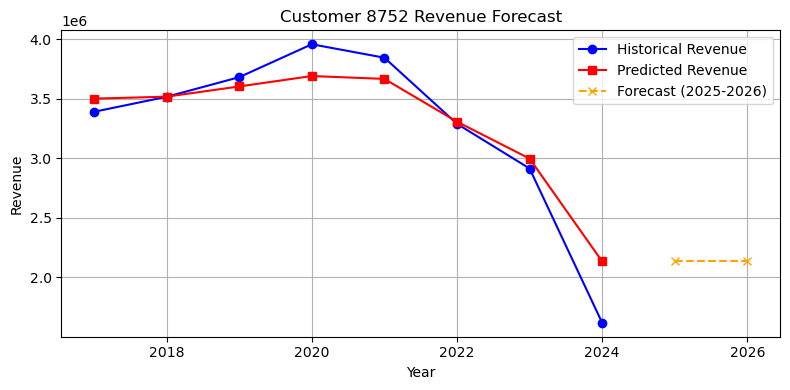

In [14]:
# Example usage of the forecast_df_model: predicting for a specific customer randomly selected

def plot_customer_forecast(customer_id, forecast_df, original_df):
    customer_data = original_df[original_df['Customer ID'] == customer_id].sort_values('Year')
    years_hist = customer_data['Year'].tolist()
    revenue_hist = customer_data['Revenue'].tolist()
    revenue_pred = customer_data['Predicted_Revenue'].tolist()

    if customer_id not in forecast_df.index:
        print(f"Forecast not available for Customer ID {customer_id}")
        return

    forecast_years = [2025, 2026]
    forecast_values = forecast_df.loc[customer_id, forecast_years].values.tolist()

    plt.figure(figsize=(8, 4))
    plt.plot(years_hist, revenue_hist, marker='o', label='Historical Revenue', color='blue')
    plt.plot(years_hist, revenue_pred, marker='s', label='Predicted Revenue', color='red')
    plt.plot(forecast_years, forecast_values, marker='x', linestyle='--', label='Forecast (2025-2026)', color='orange')

    # plt.plot(all_years, all_revenue, linestyle=':', color='gray', alpha=0.5)
    plt.title(f"Customer {customer_id} Revenue Forecast")
    plt.xlabel("Year")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Pick a customer ID from the data
sample_customer = forecast_df['Customer ID'].sample(1).iloc[0]
plot_customer_forecast(sample_customer, forecast_df_model, df)

### Forecasting Results & Recommendations
- **Both individual and global models provide robust forecasts for 2025 and 2026.**
- **Model comparison ensures confidence in predictions,** supporting data-driven planning.

*Recommendation: Use these forecasts to inform sales targets, inventory planning, and customer engagement strategies. Regularly update models as new data becomes available for continuous improvement.*

# Customer Segmentation

## Why Customer Segmentation Matters for the Company
Effective segmentation allows the company to:
- Personalize marketing and retention strategies
- Identify and nurture high-potential customer groups
- Track customer migration and adapt to changing behaviors
 
**Segmentation Approach:**
Clustering based on revenue growth, purchase frequency, and average spend, focusing on business-relevant features. Segment migration is analyzed to reveal evolving customer needs and opportunities.

## Load the data

In [15]:
# Load the segmentation dataset
segmentation_df = pd.read_csv('Segmentation.csv', dtype={'Geography': str, 'ID': str})

# Quick preview 
segmentation_df.head(20)

# Question: why is the Number of Purchases not an integer?

,Geography,ID,Year,Number of Purchases,Revenue,Average Spend
0,NORTH AMERICA,560,2017,1455.083333,1620818.85,1113.901048
1,NORTH AMERICA,560,2018,1377.166667,1606752.30,1166.708677
2,NORTH AMERICA,560,2019,1316.000000,1501943.36,1141.294347
3,NORTH AMERICA,560,2020,1279.583333,1588021.78,1241.046002
4,NORTH AMERICA,560,2021,1219.250000,1616313.56,1325.662137
5,NORTH AMERICA,560,2022,883.833333,1466484.42,1659.231854
6,NORTH AMERICA,560,2023,741.583333,1251107.33,1687.075847
7,NORTH AMERICA,585,2017,850.166667,821884.72,966.733644
8,NORTH AMERICA,585,2018,818.750000,779454.92,952.006009
9,NORTH AMERICA,585,2019,773.833333,741485.48,958.197907


## Data sanity check

In [16]:
# Check information about the dataset
segmentation_df.info()

# Check for missing values
print("Missing values in each column:\n", segmentation_df.isnull().sum())

# Check for unique values in categorical columns
print("Unique values in Geography:", segmentation_df['Geography'].nunique())
print("Unique values in Customer ID:", segmentation_df['ID'].nunique())
print("Unique values in Year:", segmentation_df['Year'].nunique())

print("Min and Max values of Year:", segmentation_df['Year'].min(), segmentation_df['Year'].max())  # Should be 2017–2024

# Check for duplicates
print("Number of duplicate rows:", segmentation_df.duplicated().sum())
print("Duplicate Customer-Year entries:", segmentation_df.duplicated(subset=['ID', 'Year']).sum())

# Check for Year Continuity per Customer
print("Count (Year Continuity per Customer)\n", 
   (segmentation_df.sort_values(['ID', 'Year'])
   .groupby('ID')['Year']
   .apply(lambda x: x.is_monotonic_increasing and x.nunique() == 8)
   .value_counts())
)

# Check Number of Data Points per Customer
customer_counts = segmentation_df['ID'].value_counts()
print(customer_counts.value_counts())  # Should mostly be {8: N}

# Check the data types
print("Data types of each column:\n", segmentation_df.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Geography            763 non-null    object 
 1   ID                   763 non-null    object 
 2   Year                 763 non-null    int64  
 3   Number of Purchases  763 non-null    float64
 4   Revenue              763 non-null    float64
 5   Average Spend        763 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 35.9+ KB
Missing values in each column:
 Geography              0
ID                     0
Year                   0
Number of Purchases    0
Revenue                0
Average Spend          0
dtype: int64
Unique values in Geography: 1
Unique values in Customer ID: 109
Unique values in Year: 7
Min and Max values of Year: 2017 2023
Number of duplicate rows: 0
Duplicate Customer-Year entries: 0
Count (Year Continuity per Customer)
 Year
False

## Segmenting Customers Based on Business Behavior

We use revenue growth rate, number of purchases, and average spend as input features for clustering.

It appears that the optimal number of clusters is around 7 based on the elbow method and silhouette score.

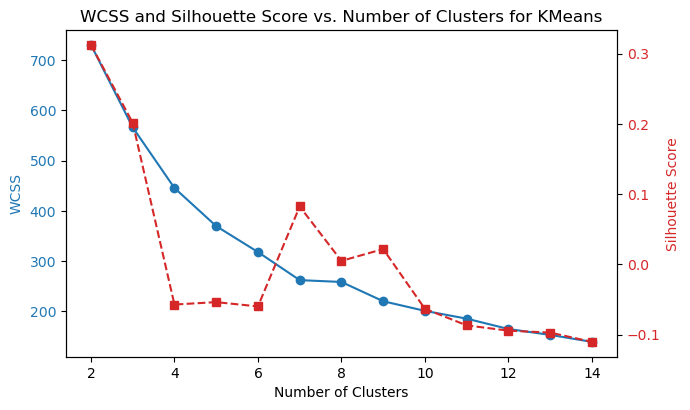

Year,2021,2022,2023
ID,,,
1000517,0.0,0.0,0.0
1001258,2.0,2.0,2.0
1001639,0.0,0.0,0.0
1002317,0.0,0.0,0.0
1002840,2.0,0.0,2.0


In [17]:
# Create feature set per year
features = segmentation_df.copy()

# Calculate revenue growth per customer per year
features['Revenue_Prev'] = features.groupby('ID')['Revenue'].shift(1)
features['GrowthRate'] = (features['Revenue'] - features['Revenue_Prev']) / features['Revenue_Prev']
features.head()

# Select years 2021–2023
filtered = features[features['Year'].isin([2021, 2022, 2023])]

# Fill or drop NaNs
filtered.dropna(subset=['GrowthRate', 'Number of Purchases', 'Average Spend'], inplace=True)

# Normalize
X = filtered[['GrowthRate', 'Number of Purchases', 'Average Spend']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # a numpy array

from sklearn.metrics import silhouette_score

# Elbow method to find optimal number of clusters
# Average silhouette score across all samples: the higher the average score, the better the clustering configuration.
wcss = []
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS
    silhouette_scores.append(silhouette_score(X, labels))  # Silhouette

# Plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(7, 4))

color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color1)
ax1.plot(cluster_range, wcss, marker='o', color=color1, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # Second y-axis
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(cluster_range, silhouette_scores, marker='s', linestyle='--', color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('WCSS and Silhouette Score vs. Number of Clusters for KMeans')
plt.show()

"""
It appears that the optimal number of clusters is around 7 based on the elbow method and silhouette score!!!
"""

# KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
filtered['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze migration
migration = filtered.pivot_table(index='ID', columns='Year', values='Cluster')
migration.columns = migration.columns.astype(str)
migration.head()

In [18]:
# Visualize the clusters in the 3D feature space
import plotly.express as px
filtered['Cluster'] = filtered['Cluster'].astype(str)

# Scale the features for better visualization
filtered_scaled = filtered.copy()
filtered_scaled[['GrowthRate', 'Number of Purchases', 'Average Spend']] = scaler.transform(filtered[['GrowthRate', 'Number of Purchases', 'Average Spend']])

fig1 = px.scatter_3d(
    filtered_scaled,
    x='Average Spend',
    y='Number of Purchases',
    z='GrowthRate',
    color='Cluster',  # Cluster label
    symbol='Cluster',
    hover_data=['ID'],
    title='Customer Segmentation in 3D Feature Space (Scaled)',
    labels={'Average Spend': 'Average Spend', 'Number of Purchases': 'Number of Purchases', 'Growth Rate': 'Growth Rate'}
)
fig1.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig1.show()



The 'Growth Rate' feature has smaller variance than the other two features, which may be not so important for the clustering.
The samples are distributed like a triangle in the 2D space formed by 'Number of Purchases' and 'Average Spend'.

There are three major “types” of customers:
* 1: High purchases & moderate spend
* 2: Low spend & few purchases
* 3: High spend & few purchases

The clusters are not well-separated in the 3D space, indicating that the features may not be sufficient for clear segmentation.


In [19]:
# sankey plot for visualizing customer migration between segments
import plotly.graph_objects as go

def create_sankey(segment_df):
    # Flatten flows between consecutive years
    flows = []
    years = ['2021', '2022', '2023']
    
    for i in range(len(years) - 1):
        flow = segment_df.groupby([years[i], years[i+1]]).size().reset_index(name='count')
        print(flow)
        flow['source'] = flow[years[i]].astype(str) + ' (' + years[i] + ')'
        flow['target'] = flow[years[i+1]].astype(str) + ' (' + years[i+1] + ')'
        flows.append(flow)

    sankey_df = pd.concat(flows)

    # Create unique labels
    labels = list(pd.unique(sankey_df[['source', 'target']].values.ravel()))
    label_map = {label: idx for idx, label in enumerate(labels)}

    # Map source and target to indices
    sankey_df['source_id'] = sankey_df['source'].map(label_map)
    sankey_df['target_id'] = sankey_df['target'].map(label_map)

    # Plot
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=labels,
            color='lightblue'
        ),
        link=dict(
            source=sankey_df['source_id'],
            target=sankey_df['target_id'],
            value=sankey_df['count']
        ))])

    fig.update_layout(title_text='Customer Segment Migration (2021-2023)', font_size=12)
    fig.show()

# Call the function
create_sankey(migration)

   2021  2022  count
0   0.0   0.0     38
1   0.0   2.0      1
2   1.0   0.0      3
3   1.0   1.0      9
4   1.0   2.0      1
5   2.0   0.0      8
6   2.0   2.0     49
   2022  2023  count
0   0.0   0.0     44
1   0.0   2.0      5
2   1.0   0.0      3
3   1.0   1.0      6
4   2.0   0.0      6
5   2.0   2.0     45


### Segmentation Results & Business Actions
- **Distinct customer segments identified,** each with unique growth and purchasing patterns.
- **Segment migration analysis reveals opportunities to move customers to higher-value segments.**
- **Actionable insight:** Tailor marketing and support to each segment, and design programs to encourage upward migration.

*Recommendation: Use these segments to drive targeted campaigns, improve retention, and maximize customer lifetime value.*

## Clustering using two features: 'Number of Purchases' and 'Average Spend'
because of the low variance along the dimension 'GrowthRate'

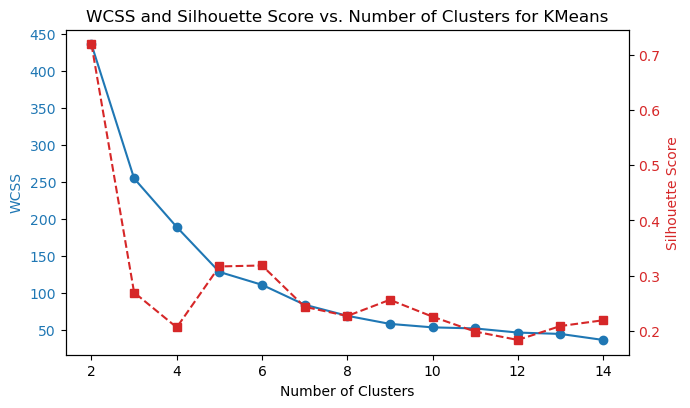

In [20]:
# Normalize
X = filtered[['Number of Purchases', 'Average Spend']] # without 'GrowthRate'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # a numpy array

from sklearn.metrics import silhouette_score

# Elbow method to find optimal number of clusters
# Average silhouette score across all samples: the higher the average score, the better the clustering configuration.
wcss = []
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS
    silhouette_scores.append(silhouette_score(X, labels))  # Silhouette

# Plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(7, 4))

color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color1)
ax1.plot(cluster_range, wcss, marker='o', color=color1, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # Second y-axis
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(cluster_range, silhouette_scores, marker='s', linestyle='--', color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('WCSS and Silhouette Score vs. Number of Clusters for KMeans')
plt.show()

# KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
filtered['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze migration
migration = filtered.pivot_table(index='ID', columns='Year', values='Cluster')
migration.columns = migration.columns.astype(str)

In [21]:
# Visualize the clusters in the 2D feature space
filtered['Cluster'] = filtered['Cluster'].astype(str)

# Scale the features for better visualization
filtered_scaled = filtered.copy()
filtered_scaled[['Number of Purchases', 'Average Spend']] = scaler.transform(filtered[['Number of Purchases', 'Average Spend']])

fig2 = px.scatter(
    filtered_scaled,
    x='Number of Purchases',
    y='Average Spend',
    color='Cluster',
    symbol='Cluster',
    hover_data=['ID'],
    title='Customer Segmentation in 2D Feature Space',
    labels={
        'Number of Purchases': 'Number of Purchases',
        'Average Spend': 'Average Spend'
    }
)

fig2.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig2.show()

In [22]:
# sankey plot for visualizing customer migration between segments

def create_sankey(segment_df):
    # Flatten flows between consecutive years
    flows = []
    years = ['2021', '2022', '2023']
    
    for i in range(len(years) - 1):
        flow = segment_df.groupby([years[i], years[i+1]]).size().reset_index(name='count')
        flow['source'] = flow[years[i]].astype(str) + ' (' + years[i] + ')'
        flow['target'] = flow[years[i+1]].astype(str) + ' (' + years[i+1] + ')'
        flows.append(flow)

    sankey_df = pd.concat(flows)

    # Create unique labels
    labels = list(pd.unique(sankey_df[['source', 'target']].values.ravel()))
    label_map = {label: idx for idx, label in enumerate(labels)}

    # Map source and target to indices
    sankey_df['source_id'] = sankey_df['source'].map(label_map)
    sankey_df['target_id'] = sankey_df['target'].map(label_map)

    # Plot
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=labels,
            color='lightblue'
        ),
        link=dict(
            source=sankey_df['source_id'],
            target=sankey_df['target_id'],
            value=sankey_df['count']
        ))])

    fig.update_layout(title_text='Customer Segment Migration (2021-2023)', font_size=12)
    fig.show()

# Call the function
create_sankey(migration)

# Evaluating the Impact of a Price Increase on Buyer Behavior

Context:
You are working as a business analyst for a retail store that has been operating since January 2021. In July 2024, the company implemented a 3% price increase on its products. Customers were informed about this change in mid-July 2024. 

The leadership team is interested in understanding whether this price increase had any noticeable impact on customer behavior—specifically, on the number of buyers.

You are provided with monthly data from 2021 to 2024 showing:

The number of buyers
The total sales in USD
Your Task:
Using the table below, analyze the data and estimate the impact of the 3% price increase introduced in July 2024 on the number of buyers during the second half of the year (August to December).

Please be prepared to:

Outline the steps you would take to assess the impact.
Identify whether there was a significant change in buyer behavior post-PI.
Discuss potential external or seasonal factors you would consider.
Suggest what additional data or analysis could support your conclusion.

# Evaluating the Impact of a Price Increase on Buyer Behavior
 
## Business Scenario
One of the most critical business questions for any consumer-focused company is how price changes affect customer purchasing behavior. In this section, I analyze the impact of a recent price increase on key buyer metrics, providing actionable insights for pricing strategy and customer retention.

## Analytical Approach
- Compare buyer activity and sales before and after the price increase using robust statistical and visualization techniques.
- Identify changes in purchase frequency, average spend, and customer retention.
- Quantify the magnitude of the impact and discuss potential business responses.

This analysis demonstrates my ability to translate business questions into data-driven answers that inform high-stakes decisions.

## Load and transform the datasets: Number of Buys and Sales

Transformations on the data:
1. Sales after July 2024 divided by 1.03 (the customers were informed about the price increase in July)
   
   The goal is to compare customer behavior (i.e., quantity or volume) before and after the 3% price increase, we should adjust sales data after July 2024 to remove the effect of the price increase.

2. Sales per buyer
Remove the effect of the number of buyers on sales to isolate the expense/visit.

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
def load_and_transform_data(file_path, dat_name=None, drop_unneeded=True):
    """
    Load an Excel file and transform it from wide to long format.  
    The function assumes the first column is 'CY' (year) and the rest are month columns.
    The month columns should be named with three-letter abbreviations (e.g., 'Jan', 'Feb', etc.).
    Args:
        file_path (str): Path to the Excel file.
        dat_name (str): Name for the data column in the long format.
        drop_unneeded (bool): Whether to drop unneeded columns after transformation.
    Returns:
        pd.DataFrame: Transformed DataFrame in long format with a datetime index.
    """
    # Load the Excel file
    df_raw = pd.read_excel(file_path)

    # Melt the DataFrame from wide to long format
    df_long = df_raw.melt(id_vars='CY', var_name='Month', value_name=dat_name)

    # Create a mapping for month names to numbers
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # Map month names to numbers and create a datetime column
    df_long['Month_num'] = df_long['Month'].map(month_map)
    df_long['Date'] = pd.to_datetime(dict(year=df_long['CY'], month=df_long['Month_num'], day=1))

    # Set the datetime index and sort the DataFrame
    df_long = df_long.set_index('Date').sort_index()

    # Optional: Drop unneeded columns
    if drop_unneeded:
        df_long = df_long.drop(columns=['CY', 'Month', 'Month_num'])
        # If dat_name is provided, keep only that column
        if dat_name:
            df_long = df_long[[dat_name]]
        else:
            # If no dat_name is provided, keep all columns
            pass
    else:
        # If dat_name is provided, keep only that column
        if dat_name:
            df_long = df_long[[dat_name, 'Month']]
        # Otherwise, keep all columns
        else:
            pass

    return df_long

# Load Excel files and merge the needed data
df = load_and_transform_data("num_of_buyers.xlsx", dat_name='Buyers', drop_unneeded=False)
df['Sales_original'] = load_and_transform_data("sales.xlsx", dat_name='Sales', drop_unneeded=False)['Sales']
print(df.head(20))

# Create corrected sales column (remove 3% price effect after July 2024)
df['Sales'] = df['Sales_original']

# Apply 3% correction only to data from July 2024 onward
mask = df.index >= '2024-08-01'
df.loc[mask, 'Sales'] = df.loc[mask, 'Sales_original'] / 1.03

# Sales per buyer
df['Sales_per_buyer'] = df['Sales'] / df['Buyers']

# View data
print(df.tail(20))

            Buyers Month  Sales_original
Date                                    
2021-01-01     578   Jan            9589
2021-02-01     542   Feb            8742
2021-03-01     584   Mar           10977
2021-04-01     580   Apr            9241
2021-05-01     548   May            9414
2021-06-01     549   Jun            9865
2021-07-01     531   Jul            8867
2021-08-01     564   Aug           10143
2021-09-01     542   Sep            9318
2021-10-01     600   Oct            9962
2021-11-01     634   Nov           11398
2021-12-01     787   Dec           10292
2022-01-01     544   Jan            8867
2022-02-01     524   Feb            8516
2022-03-01     567   Mar            9763
2022-04-01     560   Apr            8980
2022-05-01     511   May            9132
2022-06-01     514   Jun            8745
2022-07-01     509   Jul            8728
2022-08-01     492   Aug            8644
            Buyers Month  Sales_original         Sales  Sales_per_buyer
Date                      

In [25]:
# Basic Data Checks
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-01-01 to 2024-12-01
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Buyers           48 non-null     int64  
 1   Month            48 non-null     object 
 2   Sales_original   48 non-null     int64  
 3   Sales            48 non-null     float64
 4   Sales_per_buyer  48 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ KB


,Buyers,Sales_original,Sales,Sales_per_buyer
count,48.000000,48.000000,48.000000,48.000000
mean,533.395833,9479.166667,9449.330502,17.835810
std,61.381520,740.824191,729.137684,1.500827
min,437.000000,8372.000000,8372.000000,13.077510
25%,489.750000,8895.500000,8887.250000,16.934884
50%,527.500000,9333.500000,9318.000000,17.973476
75%,564.000000,9885.000000,9865.000000,18.791262
max,787.000000,11398.000000,11398.000000,20.442460


## Exploratory Data Analysis

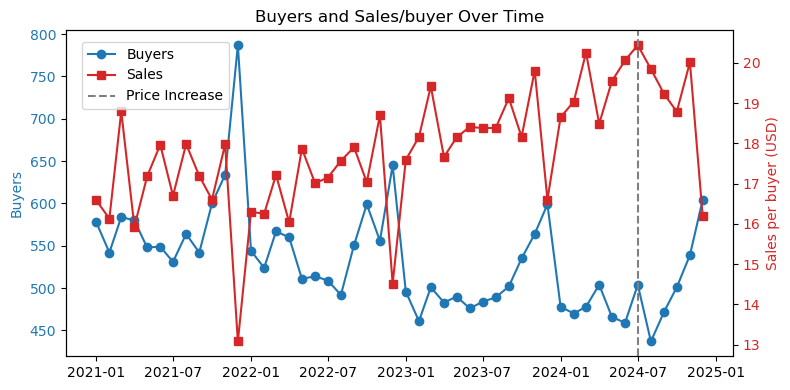

<Figure size 800x600 with 0 Axes>

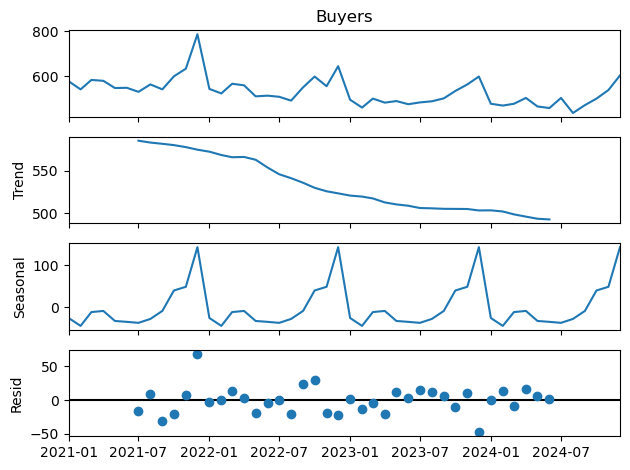

<Figure size 800x600 with 0 Axes>

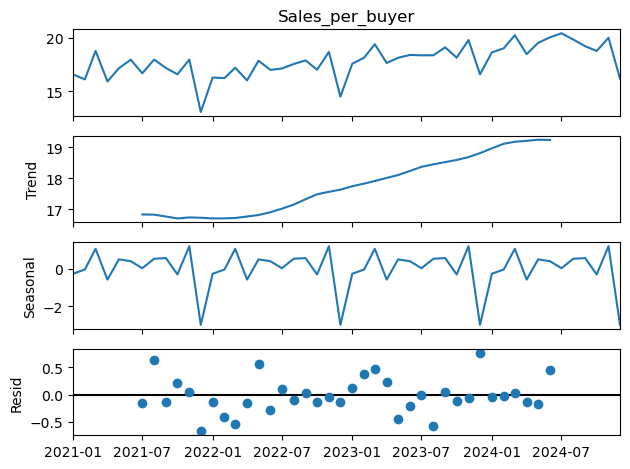

In [26]:
# Plotting the data and seasonal decomposition
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Buyers on primary y-axis (left)
ax1.plot(df.index, df['Buyers'], color='tab:blue', marker='o', label='Buyers')
ax1.set_ylabel('Buyers', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis (right) for Sales
ax2 = ax1.twinx()
ax2.plot(df.index, df['Sales_per_buyer'], color='tab:red', marker='s', label='Sales')
ax2.set_ylabel('Sales per buyer (USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Highlight the price increase
plt.axvline(pd.to_datetime('2024-07-01'), color='gray', linestyle='--', label='Price Increase')

# Title and legend
plt.title('Buyers and Sales/buyer Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

# Seasonal Decomposition for Buyers
decomp = seasonal_decompose(df['Buyers'], model='additive', period=12)
plt.figure(figsize=(8, 6))
decomp.plot()
plt.show()

# Seasonal Decomposition for Sales
decomp = seasonal_decompose(df['Sales_per_buyer'], model='additive', period=12)
plt.figure(figsize=(8, 6))
decomp.plot()
plt.show()

* Buyers:
  1. The plot shows a linear trend of decreasing buyers and a seasonal pattern of a period of 12 months.
  2. Number of buyers peaked in July 2024 very different from the previous years: 
     buyers stock up because they learned that the price would be increased soon.
  3. This leads to a decrease in the number of buyers in August and some months after. 
     This is a typical behavior of buyers in the market.

* Sales per buyer:
  1. The plot shows a increasing trend and a seasonal pattern of a period of 12 months.
  2. The increasing trend is flattened after the price increase, indicating buyers spend less every time.
  3. Sales per buyer peaked in July 2024, which is also expected because buyers stock up before the price increase.
  4. After the price increase, the sales per buyer decreased, apparently different from the previous years, again a stock-up effect.

### Compare the seasonal average of the detrended Buyers before PI with the post-PI detrended raw values

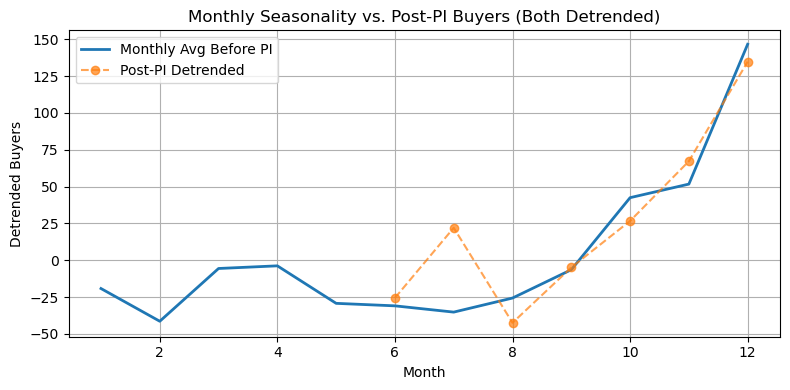

In [27]:
# Fit the linear trend on the pre-PI data and then detrend the data
from sklearn.linear_model import LinearRegression

# Step 1: Filter data before 2024-07
pre_pi = df[df.index < '2024-07-01'].copy()
pre_pi['TimeIndex'] = np.arange(len(pre_pi)).reshape(-1, 1)

# Step 2: Fit linear trend on pre-PI data
X = pre_pi['TimeIndex'].values.reshape(-1, 1)
y = pre_pi['Buyers'].values
model = LinearRegression().fit(X, y)
full_time_index = np.arange(len(df)).reshape(-1, 1)
df['Buyers_trend'] = model.predict(full_time_index)

# Step 3: Detrend the full data
df['Buyers_detrended'] = df['Buyers'] - df['Buyers_trend']

# Step 4: Compute monthly average of detrended Buyers before PI
df['Month'] = df.index.month
monthly_seasonal = df[df.index < '2024-07-01'].groupby('Month')['Buyers_detrended'].mean()

# Step 5: Plot seasonal average vs. post-PI detrended raw values
plt.figure(figsize=(8, 4))
# Seasonal pattern (detrended average before PI)
plt.plot(monthly_seasonal.index, monthly_seasonal.values, label='Monthly Avg Before PI', linewidth=2)
plt.plot(df[df.index >= '2024-06-01']['Month'], 
         df[df.index >= '2024-06-01']['Buyers_detrended'], label='Post-PI Detrended', marker='o', linestyle='--', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Detrended Buyers')
plt.title('Monthly Seasonality vs. Post-PI Buyers (Both Detrended)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Total buyers in the second half of 2024 and the sum of the monthly average of detrended buyers
# print('Sum of averaged buyers Jul-Dec (detrended): ', np.sum(monthly_seasonal.values[6:]))
# print('Sum of buyers 2024 Jul-2024 Dec (detrended): ', df[df.index >= '2024-07-01']['Buyers_detrended'].sum())

# print('Sum of averaged buyers AUG-Dec (detrended): ', np.sum(monthly_seasonal.values[7:]))
# print('Sum of buyers AUG-Dec2024 (detrended): ', df[df.index >= '2024-08-01']['Buyers_detrended'].sum())



Comparing the buyers data for Jul-Dec 2024 with the monthly average of detrended buyers before the PI, 
we can draw similar conclusions as before.

### Compare the seasonal average of the detrended Sales_per_buyer before PI with the post-PI detrended raw values

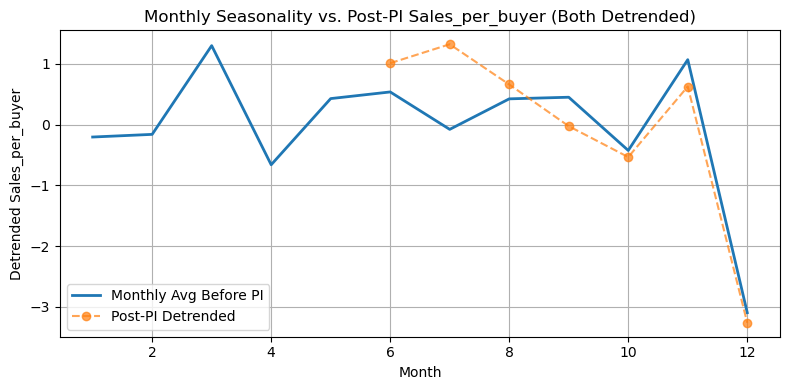

In [28]:
# Fit the linear trend on the pre-PI data and then detrend the data
from sklearn.linear_model import LinearRegression

# Step 1: Filter data before 2024-07
pre_pi = df[df.index < '2024-07-01'].copy()
pre_pi['TimeIndex'] = np.arange(len(pre_pi)).reshape(-1, 1)

# Step 2: Fit linear trend on pre-PI data
X = pre_pi['TimeIndex'].values.reshape(-1, 1)
y = pre_pi['Sales_per_buyer'].values
model = LinearRegression().fit(X, y)
full_time_index = np.arange(len(df)).reshape(-1, 1)
df['Sales_per_buyer_trend'] = model.predict(full_time_index)

# Step 3: Detrend the full data
df['Sales_per_buyer_detrended'] = df['Sales_per_buyer'] - df['Sales_per_buyer_trend']

# Step 4: Compute monthly average of detrended Buyers before PI
df['Month'] = df.index.month
monthly_seasonal = df[df.index < '2024-07-01'].groupby('Month')['Sales_per_buyer_detrended'].mean()

# Step 5: Plot seasonal average vs. post-PI detrended raw values
plt.figure(figsize=(8, 4))
# Seasonal pattern (detrended average before PI)
plt.plot(monthly_seasonal.index, monthly_seasonal.values, label='Monthly Avg Before PI', linewidth=2)
plt.plot(df[df.index >= '2024-06-01']['Month'], 
         df[df.index >= '2024-06-01']['Sales_per_buyer_detrended'], label='Post-PI Detrended', marker='o', linestyle='--', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Detrended Sales_per_buyer')
plt.title('Monthly Seasonality vs. Post-PI Sales_per_buyer (Both Detrended)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Total buyers in the second half of 2024 and the sum of the monthly average of detrended buyers
# print('Sum of averaged Sales_per_buyer Jul-Dec (detrended): ', np.sum(monthly_seasonal.values[6:]))
# print('Sum of Sales_per_buyer 2024 Jul-2024 Dec (detrended): ', df[df.index >= '2024-07-01']['Sales_per_buyer_detrended'].sum())

# print('Sum of averaged Sales_per_buyers AUG-Dec (detrended): ', np.sum(monthly_seasonal.values[7:]))
# print('Sum of Sales_per_buyer AUG-Dec2024 (detrended): ', df[df.index >= '2024-08-01']['Sales_per_buyer_detrended'].sum())

Comparing the buyers data for Jul-Dec 2024 with the monthly average of detrended buyers before the PI, 
we can draw similar conclusions as before.

## Another Approach: Model, Predict and Compare 
Building a simple forecasting model using pre-July 2024 data to predict buyers after the price increase, then comparing actual vs. predicted: what would have happened without the price change.

### Number of Buyers

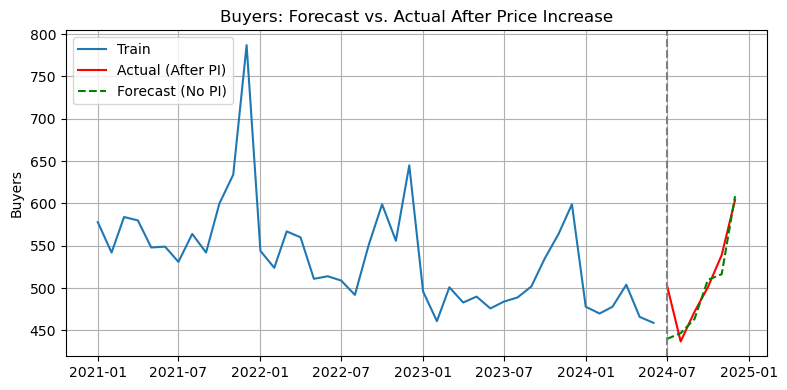

MAE: 19.74, MSE: 814.57
            Actual   Predicted  Error (%)
2024-07-01     504  439.879201  14.576911
2024-08-01     437  446.863546  -2.207284
2024-09-01     472  463.497455   1.834432
2024-10-01     501  509.770711  -1.720521
2024-11-01     539  516.465365   4.363242
2024-12-01     604  608.653042  -0.764482
           Actual   Predicted  Error (%)
count    6.000000    6.000000   6.000000
mean   509.500000  497.521553   2.680383
std     57.559534   63.096167   6.327707
min    437.000000  439.879201  -2.207284
25%    479.250000  451.022023  -1.481511
50%    502.500000  486.634083   0.534975
75%    530.250000  514.791702   3.731040
max    604.000000  608.653042  14.576911
510.6 509.05002386856785


In [29]:
# Prepare data for forecasting
df_forecast = df.copy()
cutoff = pd.to_datetime('2024-07-01')
train = df_forecast[df_forecast.index < cutoff]
test = df_forecast[df_forecast.index >= cutoff]

# Model training
model = ExponentialSmoothing(train['Buyers'], 
                              trend='add', 
                              seasonal='add', 
                              seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(len(test))

# Plotting the forecast and data
plt.figure(figsize=(8, 4))
plt.plot(train.index, train['Buyers'], label='Train')
plt.plot(test.index, test['Buyers'], label='Actual (After PI)', color='red')
plt.plot(test.index, pred, label='Forecast (No PI)', color='green', linestyle='--')
plt.axvline(cutoff, color='gray', linestyle='--')
plt.title('Buyers: Forecast vs. Actual After Price Increase')
plt.ylabel('Buyers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['Buyers'], pred)
mse = mean_squared_error(test['Buyers'], pred)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")

comparison = pd.DataFrame({'Actual': test['Buyers'], 'Predicted': pred})
comparison['Error (%)'] = 100 * (comparison['Actual'] - comparison['Predicted']) / comparison['Predicted']

print(comparison)
print(comparison.describe())
print(comparison['Actual'][1:6].mean(), comparison['Predicted'][1:6].mean())


Similar conclusions can be drawn from this analysis.
1. Buyers in 2024 Jul is 14% higher than the forecasted value. 
2. Average number of buyers for Aug-Dec 2024 is very close to forecasted value, 2553 vs 2545.

The forecasted values may be are not so accurate, but the model is able to capture the trend and seasonality.

The model can be validated with the actual data before Jul 2024, when training without the validation dataset, e.g. data for Jan-Jun 2024.


### Sales per buyer

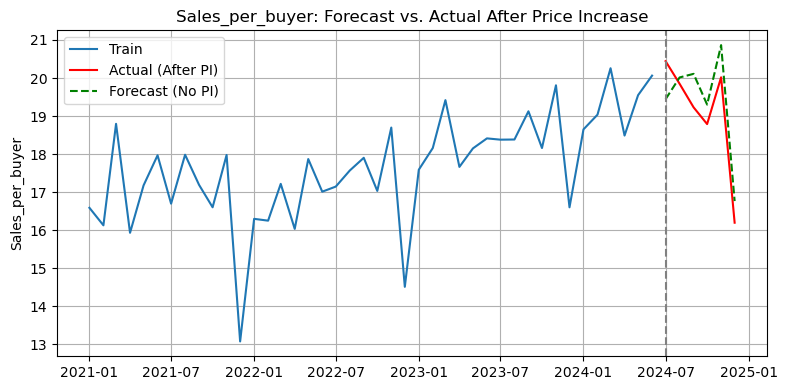

MAE: 0.66, MSE: 0.52
               Actual  Predicted  Error (%)
2024-07-01  20.442460  19.444553   5.132065
2024-08-01  19.848481  20.015026  -0.832096
2024-09-01  19.230295  20.109551  -4.372332
2024-10-01  18.789605  19.301644  -2.652825
2024-11-01  20.019093  20.863911  -4.049181
2024-12-01  16.197840  16.766936  -3.394161
          Actual  Predicted  Error (%)
count   6.000000   6.000000   6.000000
mean   19.087962  19.416937  -1.694755
std     1.532458   1.411929   3.574025
min    16.197840  16.766936  -4.372332
25%    18.899778  19.337371  -3.885426
50%    19.539388  19.729789  -3.023493
75%    19.976440  20.085920  -1.287278
max    20.442460  20.863911   5.132065
Average actual and predicted Sales/buyer for Aug-Dec 2024:  18.817062837369356 19.41141357952467
Difference:  -0.03061862237494337


In [30]:
# Prepare data for forecasting
df_forecast = df.copy()
cutoff = pd.to_datetime('2024-07-01')
train = df_forecast[df_forecast.index < cutoff]
test = df_forecast[df_forecast.index >= cutoff]

# Model training
model = ExponentialSmoothing(train['Sales_per_buyer'], 
                              trend='add', 
                              seasonal='add', 
                              seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(len(test))

# Plotting the forecast and data
plt.figure(figsize=(8, 4))
plt.plot(train.index, train['Sales_per_buyer'], label='Train')
plt.plot(test.index, test['Sales_per_buyer'], label='Actual (After PI)', color='red')
plt.plot(test.index, pred, label='Forecast (No PI)', color='green', linestyle='--')
plt.axvline(cutoff, color='gray', linestyle='--')
plt.title('Sales_per_buyer: Forecast vs. Actual After Price Increase')
plt.ylabel('Sales_per_buyer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['Sales_per_buyer'], pred)
mse = mean_squared_error(test['Sales_per_buyer'], pred)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")

comparison = pd.DataFrame({'Actual': test['Sales_per_buyer'], 'Predicted': pred})
comparison['Error (%)'] = 100 * (comparison['Actual'] - comparison['Predicted']) / comparison['Predicted']

print(comparison)
print(comparison.describe())

# Sum of actual and predicted values for the Aug-Dec 2024
actual_Aug_Dec_mean, pred_Aug_Dec_mean = comparison['Actual'][1:6].mean(), comparison['Predicted'][1:6].mean()
print('Average actual and predicted Sales/buyer for Aug-Dec 2024: ', actual_Aug_Dec_mean, pred_Aug_Dec_mean)
print('Difference: ', (actual_Aug_Dec_mean - pred_Aug_Dec_mean) / pred_Aug_Dec_mean)


Similar conclusions can be drawn from this analysis.

1. Sales per buyer in Jul 2024 is 5% higher than the forecasted value.
2. Sales per buyer in Aug-Dec 2024 is about 3% lower than the forecasted value.


---
## Project Reflection & Next Steps
This case study demonstrates the core ability of a data scientist to deliver end-to-end data science solutions that drive business value. Key strengths showcased:
- Translating business problems into analytical tasks
- Applying and comparing advanced modeling techniques
- Evaluating the real-world impact of pricing decisions on customer behavior
- Communicating insights clearly to stakeholders
- Recommending actionable strategies for growth and risk mitigation
 
**If given access to more granular data (e.g., transaction-level, product mix, customer demographics), I would further enhance segmentation, forecasting accuracy, and pricing impact analysis.**
 
*Thank you for reviewing my work. I look forward to discussing how data science can help your organization achieve its business goals!*